## Overview

This homework assignment continues to use school data from the previous assignment.

Download the 2015-16 district-level fiscal data from the National Center for Education Statistics’ Common Core of Data:
• https://nces.ed.gov/ccd/f33agency.asp

The 2015-16 performance statistics on graduation rate and state assessments on mathematics and reading/language arts are available from the EDFacts website:
• https://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html

Additionally, the 2015-16 district-level “universe” survey data provides statistics about enrollment disaggregated by demographics like gender, race, disability status, etc:
• https://nces.ed.gov/ccd/pubagency.asp

These datasets can be linked based on the LEA IDs.

In [39]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

In [40]:
def load_data():
    fiscal_df = pd.read_csv('../input/Sdf16_1a.txt', sep='\t')
    math_df = pd.read_csv('../input//math-achievement-lea-sy2015-16.csv')
    arts_df = pd.read_csv('../input/rla-achievement-lea-sy2015-16.csv')
    demographics_df = pd.read_csv('../input/ccd_lea_052_1516_w_1a_011717.csv')
    disability_df = pd.read_csv('../input/ccd_lea_002089_1516_w_1a_011717.csv')
    return fiscal_df, math_df, arts_df, demographics_df, disability_df

In [41]:
fiscal_df, math_df, arts_df, demographics_df, disability_df = load_data()
fiscal_df = fiscal_df[fiscal_df['TFEDREV']>0]

### Problem 1

For the districts you selected for budget cuts in HW 3 Problem 4, calculate and visualize the proportion of
each district’s total funding that will be lost.

Which districts will be affected by your budget cuts the most?

In [42]:
def unblur_column(math_df, column_name):
    column_new_values = []
    column_old_values = math_df[column_name]
#     column_old_values = ['42', '45-49', 'LT50', 'LE20', 'GT20', 'GE50']
    for value in column_old_values:
        new_value = None
        if '-' in value:
            value_array = value.split('-')
            new_value = random.randint(int(value_array[0]), int(value_array[1]))
        elif 'LT' in value:
            begin = 0
            end = int(value[2:])
            new_value = random.randrange(begin, end)
        elif 'LE' in value:
            begin = 0
            end = int(value[2:])
            new_value = random.randint(begin, end)
        elif 'GT' in value:
            begin = int(value[2:]) + 1
            end = 100
            new_value = random.randint(begin, end)
        elif 'GE' in value:
            begin = int(value[2:])
            end = 100
            new_value = random.randint(begin, end)
        elif 'PS' in value:
            new_value = random.randint(0, 100)
        else:
            new_value = int(value)
        column_new_values.append(new_value)
    return column_new_values

In [43]:
def run_1_1(fiscal_df):
    sum_value = fiscal_df[['TFEDREV']].sum().values
    result = sum_value * 0.15
    return result

In [44]:
def run_1_2(fiscal_df, math_df, fifteen_percent_fed_budget):
    # Get the schools based on the criteria
    input_df = math_df[['LEAID', 'ALL_MTH00PCTPROF_1516']]
    input_df['ALL_MTH00PCTPROF_1516'] = unblur_column(math_df, 'ALL_MTH00PCTPROF_1516')
    
    # Get the 75 percent quartile as the cutoff criteria
    seventy_five_percent_quantile = input_df['ALL_MTH00PCTPROF_1516'].quantile(.75)
    filtered_df = input_df[input_df['ALL_MTH00PCTPROF_1516']<seventy_five_percent_quantile]

    # Get the lead_ids for which budget has been approved
    approved_lead_ids = list(filtered_df['LEAID'].unique())
    
    result_df = fiscal_df[fiscal_df['LEAID'].isin(approved_lead_ids)][['LEAID', 'NAME', 'TFEDREV']]
    result_df['percentage_cut'] = result_df['TFEDREV']/result_df['TFEDREV'].sum()
    result_df['cut_amount'] = result_df['percentage_cut'] * fifteen_percent_fed_budget
    result_df['cut_proportion'] = result_df['cut_amount']/result_df['TFEDREV']
    result_df.sort_values(by='percentage_cut', ascending=True, inplace=True)
    print(result_df)
    result_df.sort_values(by='cut_proportion', ascending=True, inplace=True)
    
    return result_df

In [45]:
def run_1(fiscal_df, math_df):
    fifteen_percent_fed_budget = run_1_1(fiscal_df)
    print("15 percent of federal budget is: {}".format(fifteen_percent_fed_budget))
    result_df = run_1_2(fiscal_df, math_df, fifteen_percent_fed_budget)
    print(result_df[['LEAID', 'NAME', 'percentage_cut', 'cut_amount', 'cut_proportion']])

In [46]:
run_1(fiscal_df, math_df)

15 percent of federal budget is: [8.3404113e+09]
         LEAID                               NAME     TFEDREV  percentage_cut  \
7027   2601042                 Branch Line School        1000    5.616731e-08   
6794   2600121       Honey Creek Community School        2000    1.123346e-07   
727     400931                ECA - Arizona  Inc.        2000    1.123346e-07   
9157   3004920                      Broadview H S        3000    1.685019e-07   
391     400278  Deer Valley Charter Schools  Inc.        3000    1.685019e-07   
...        ...                                ...         ...             ...   
7232   2612000       Detroit City School District   193905000    1.089112e-02   
15635  4700148                      Shelby County   212572000    1.193960e-02   
15038  4218990               Philadelphia City SD   271369000    1.524207e-02   
9784   3200060       CLARK COUNTY SCHOOL DISTRICT   277628000    1.559362e-02   
1904    622710                Los Angeles Unified  109140000

/Users/karangm/PycharmProjects/ds5500-hw4/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Philadelphia City SD, CLARK COUNTY SCHOOL DISTRICT & Los Angeles Unified will have the highest percentage of budget cuts in amount. 

But if take the proportions, for all the schools which has budget cuts it will have the same proportion because of the solution proposed.

To explain on that, to do the budget cut after we filtered schools on a particular criteria,
1. Calculate the 15% of the total budget amount -> fifteen_percent_fed_budget
2. For each potential case, we take the ('TFEDREV' of a case)/Sum of all ('TFEDREV' of a case) -> percentage_cut
3. percentage_cut * fifteen_percent_fed_budget to get value for each potential case -> budget_cut_for_a_case
4. If we put all in one formula:
   (('TFEDREV' of a case)/Sum of all ('TFEDREV' of a case)) * fifteen_percent_fed_budget =  budget_cut_for_a_case
5. To calculate proportion, we have to calculate budget_cut_for_a_case/('TFEDREV' of a case) which will be equal to fifteen_percent_fed_budget/Sum of all ('TFEDREV' of a case)) which is a constant

### Problem 2

A common problem with purely data-driven solutions is that they can inadvertently perpetuate hidden pre-existing biases in the data, and further disadvantage groups that are already disadvantaged. Calculate the proportion of enrolled students by race for each district, then visualize the distributions of these for districts that received budget cuts versus districts that did not receive budget cuts. Comment on whether the the distributions appear to be the same or different. Did your selection include any hidden biases, or manage to avoid them?

In [47]:
def get_proportion_2_1(df):
    df['BL_Proportion'] = df['BL'] / df['TOTAL']
    df['AM_Proportion'] = df['AM'] / df['TOTAL']
    df['HP_Proportion'] = df['HP'] / df['TOTAL']
    df['AS_Proportion'] = df['AS'] / df['TOTAL']
    df['WH_Proportion'] = df['WH'] / df['TOTAL']
    df['HI_Proportion'] = df['HI'] / df['TOTAL']
    df['TR_Proportion'] = df['TR'] / df['TOTAL']
    return df

In [48]:
def plot_2_1(result_budget_cut_df, result_budget_no_cut_df):
    fig, ax = plt.subplots(ncols=2, figsize=(25,15))
    ax[0].bar(result_budget_cut_df.index[8:], result_budget_cut_df[8:])
    ax[0].set_title('Budget Cut')
    ax[0].set_xlabel('Race')
    ax[0].set_ylabel('Proportion')
    ax[0].set_ylim([0, 1])
    
    ax[1].bar(result_budget_no_cut_df.index[8:], result_budget_no_cut_df[8:])
    ax[1].set_title('No Budget Cut')
    ax[1].set_xlabel('Race')
    ax[1].set_ylabel('Proportion')
    ax[1].set_ylim([0, 1])

    fig.suptitle('Distribution of Race for Budget Cut vs No Budget cut')
    fig.savefig('../output/2.png')
    plt.show()

In [49]:
def run_2_1(fiscal_df, math_df, demographics_df):
    # Get the schools based on the criteria
    input_df = math_df[['LEAID', 'ALL_MTH00PCTPROF_1516']]
    input_df['ALL_MTH00PCTPROF_1516'] = unblur_column(math_df, 'ALL_MTH00PCTPROF_1516')
    
    # Get the 75 percent quartile as the cutoff criteria
    seventy_five_percent_quantile = input_df['ALL_MTH00PCTPROF_1516'].quantile(.75)
    input_df['BUDGET_CUT_FLAG'] = input_df['ALL_MTH00PCTPROF_1516']<seventy_five_percent_quantile
    
    input_df = pd.merge(input_df, demographics_df, on='LEAID')    
    result_budget_cut_df = input_df[input_df['BUDGET_CUT_FLAG'] == True][['AM', 'AS','HI', 'BL', 'WH', 'HP', 'TR', 'TOTAL']].sum()
    result_budget_no_cut_df = input_df[input_df['BUDGET_CUT_FLAG'] == False][['AM', 'AS','HI', 'BL', 'WH', 'HP', 'TR', 'TOTAL']].sum()
    
    result_budget_cut_df = get_proportion_2_1(result_budget_cut_df)
    result_budget_no_cut_df = get_proportion_2_1(result_budget_no_cut_df)
    
    plot_2_1(result_budget_cut_df, result_budget_no_cut_df)

/Users/karangm/PycharmProjects/ds5500-hw4/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/karangm/PycharmProjects/ds5500-hw4/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


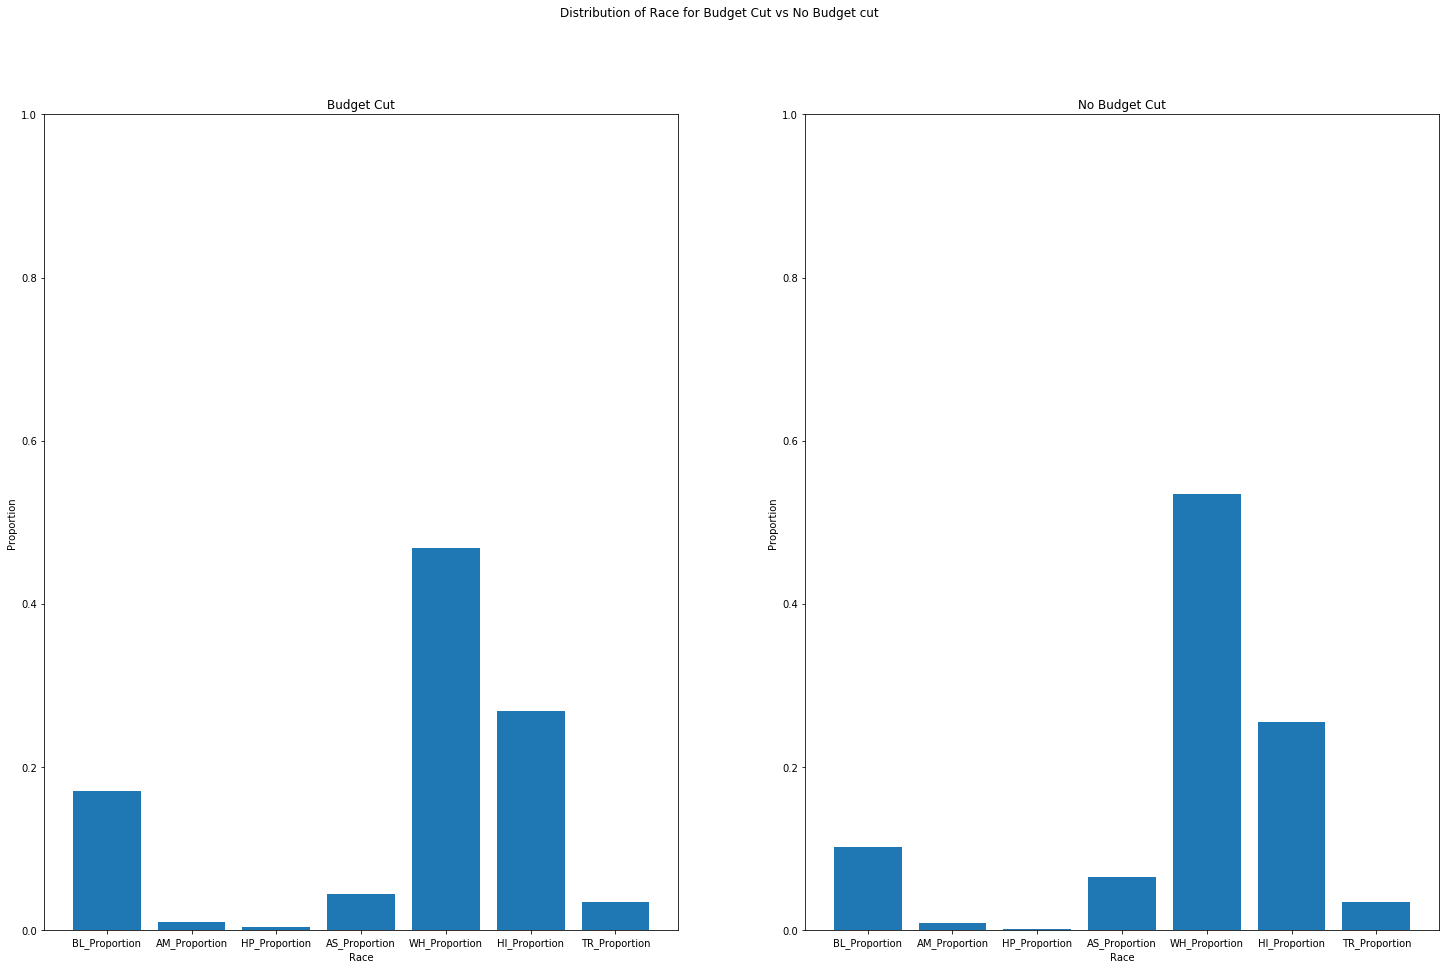

In [50]:
run_2_1(fiscal_df, math_df, demographics_df)

You can clearly observe race - BL_Proportion proportion is significantly higher in the districts that received budget cuts. Looks like solution incorporated bias.

### Problem 3

Calculate the proportion of enrolled students by disability status (students with an IEP under IDEA) for each district, then visualize the distributions of these proportions for districts that received budget cuts versus districts that did not receive budget cuts.

Comment on whether the the distributions appear to be the same or different. Did your selection include any
hidden biases, or manage to avoid them?

In [51]:
def get_proportion_3_1(df):
    df['Disability_Proportion'] = df['SPECED'] / df['TOTAL']
    return df

In [52]:
def plot_3_1(result_budget_cut_df, result_budget_no_cut_df):
    print(result_budget_cut_df, result_budget_no_cut_df)
    fig, ax = plt.subplots(ncols=2, figsize=(25,15))
    ax[0].bar(result_budget_cut_df.index[2:], result_budget_cut_df[2:])
    ax[0].set_title('Budget Cut')
    ax[0].set_ylabel('Proportion')
    ax[0].set_ylim([0, 0.2])
    
    ax[1].bar(result_budget_no_cut_df.index[2:], result_budget_no_cut_df[2:])
    ax[1].set_title('No Budget Cut')
    ax[1].set_ylabel('Proportion')
    ax[1].set_ylim([0, 0.2])

    fig.suptitle('Distribution of Disability for Budget Cut vs No Budget cut')
    fig.savefig('../output/3.png')
    plt.show()

In [53]:
def run_3_1(fiscal_df, math_df, demographics_df, disability_df):
    # Get the schools based on the criteria
    input_df = math_df[['LEAID', 'ALL_MTH00PCTPROF_1516']]
    input_df['ALL_MTH00PCTPROF_1516'] = unblur_column(math_df, 'ALL_MTH00PCTPROF_1516')
    
    # Get the 75 percent quartile as the cutoff criteria
    seventy_five_percent_quantile = input_df['ALL_MTH00PCTPROF_1516'].quantile(.75)
    input_df['BUDGET_CUT_FLAG'] = input_df['ALL_MTH00PCTPROF_1516'] < seventy_five_percent_quantile
    
    input_df = pd.merge(input_df, disability_df[['LEAID','SPECED']], on='LEAID')   
    input_df = pd.merge(input_df, demographics_df[['LEAID','TOTAL']], on='LEAID') 
    result_budget_cut_df = input_df[input_df['BUDGET_CUT_FLAG'] == True][['SPECED', 'TOTAL']].sum()
    result_budget_no_cut_df = input_df[input_df['BUDGET_CUT_FLAG'] == False][['SPECED', 'TOTAL']].sum()
      
    result_budget_cut_df = get_proportion_3_1(result_budget_cut_df)
    result_budget_no_cut_df = get_proportion_3_1(result_budget_no_cut_df)
    
    plot_3_1(result_budget_cut_df, result_budget_no_cut_df)

/Users/karangm/PycharmProjects/ds5500-hw4/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/karangm/PycharmProjects/ds5500-hw4/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


SPECED                   5.154194e+06
TOTAL                    3.740810e+07
Disability_Proportion    1.377828e-01
dtype: float64 SPECED                   1.487897e+06
TOTAL                    1.299626e+07
Disability_Proportion    1.144866e-01
dtype: float64


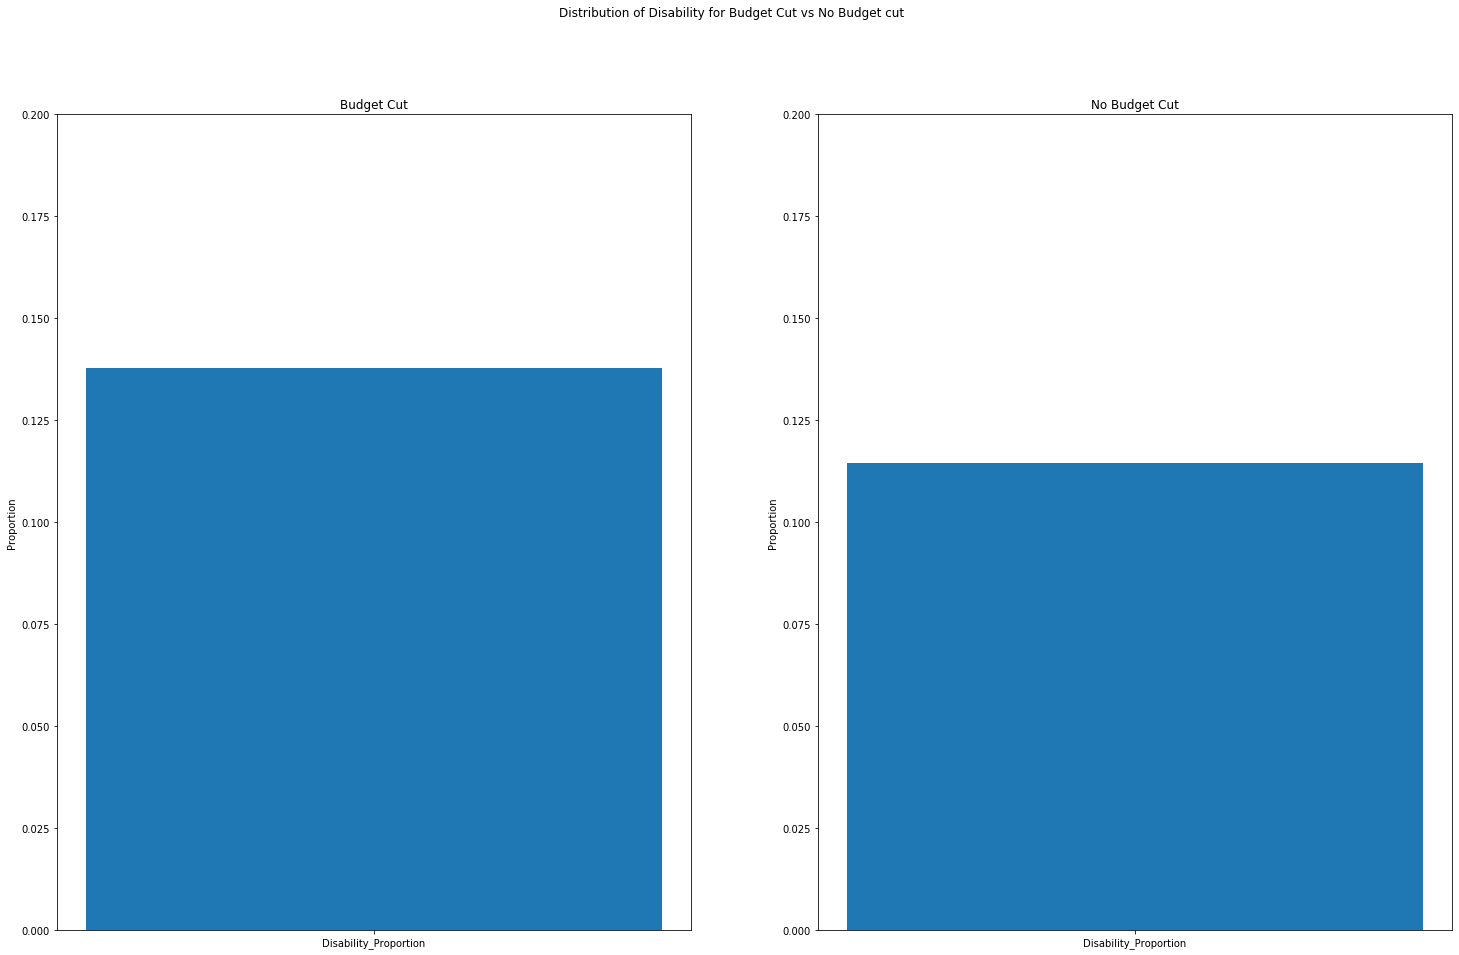

In [54]:
run_3_1(fiscal_df, math_df, demographics_df, disability_df)

The proportion disability distribution for budget cut districts and no budget cut districts seems to be very close to each other. Very negligible bias.

### Problem 4

Choose and critique one of your fellow classmates’ selection of schools for budget cuts in HW 3 Problem 4 and Problem 5. What was the justification of their selection? Discuss any advantages or disadvantages of their approach.

I chose https://github.com/manvitamarkala/DS-5500-HW3

The solution presented did not consider any performance related criteria to identify which of them should have budget cuts. However a surplus was calculated from the total budget a school has and the corresponding expenditure. Sort the districts descending on the surplus budget. If the surplus amount is greater than the federal budget for that particular district, a value equal to a federal amount of that district is substracted from the 15 percent federal budget amount. 

In a way the solution is appreciable for a fact that only those will be chosen where fedral budget wouldn't matter. However it that could have been combined with a powerful selection critieria, it may have been more effective.

### Problem 5
Summarize and comment on what you learned from one the special topics lectures (MapReduce + Hadoop, Visualization, Causal Inference, or the Industry Panel) of your choice.

I would like to talk about the MapReduce + Hadoop lecture. The lecturer started off with clear explanation of why we need Map Reduce kind of environment to process Big Data. The explanation was in simpler terms and even a student with no prior knowledge can get a clear understanding. He also threw in some important facts about how Map Reduce was originally started by a professor in Northeastern University. Overall a nice lecture.